# Pseudo-Points in Additive Regression

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/Stheno.jl/blob/master/examples/gppp_and_pseudo_points/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/gppp_and_pseudo_points/).*

In [1]:
using AbstractGPs, Plots, Random, Stheno
gr();

Define model.

In [2]:
σ², ω, T = 1e0, 1.0, 25.0;
f = @gppp let
    f1 = periodic(GP(SEKernel()), ω)
    f2 = GP(0.1 * SEKernel())
    f3 = f1 + f2
end;

Sample from marginal process to generate toy data.

In [3]:
rng = MersenneTwister(123456);
S = 25;
x = GPPPInput(:f3, range(0.0, T; length=300));
fx = f(x, σ²);
y = rand(rng, fx);

xp_ = range(-2.5, T + 2.5; length=500);

Plots for stuff.

In [4]:
f₁′_plot, f₂′_plot, f₃′_plot = plot(), plot(), plot();

posterior_plot = plot();
approx_in_marginal_posterior_plot = plot();
approx_in_latents_posterior_plot = plot();



##################################### Exact Inference ######################################

Compute the posterior processes, sample from them, and compute marginals.

In [5]:
@show logpdf(fx, y)
f′ = posterior(fx, y);
xp_f1 = GPPPInput(:f1, xp_);
xp_f2 = GPPPInput(:f2, xp_);
xp_f3 = GPPPInput(:f3, xp_);
xp = BlockData(xp_f1, xp_f2, xp_f3);
f′xp = rand(f′(xp, 1e-9), S);
f₁′xp, f₂′xp, f₃′xp = split(xp, f′xp);

items = [
    (xp_f1, f₁′xp, :red, "exact", f₁′_plot),
    (xp_f2, f₂′xp, :red, "", f₂′_plot),
    (xp_f3, f₃′xp, :red, "", f₃′_plot),
];

logpdf(fx, y) = -465.9934901401266


Plot posterior marginals and samples.

In [6]:
for (x, samples, colour, name, plt) in items
    plot!(plt, xp_, f′(x); fillalpha=0.2, color=colour, label=name);
    plot!(plt, xp_, samples; alpha=0.3, color=colour, label="", linewidth=1);
end

Plot observations.

In [7]:
scatter!(posterior_plot, x.x, y;
    markercolor=:blue,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.7,
    label="",
);



##################### Approximate inference with pseudo-data in f3 #########################

Compute approximate posterior process.

In [8]:
M3 = 25;
z = GPPPInput(:f3, collect(range(0, T; length=M3)));
u = f(z, 1e-9);
f′_approx = posterior(VFE(u), fx, y);

@show elbo(VFE(u), fx, y);

items = [
    (xp_f1, :green, "Z in f3", f₁′_plot),
    (xp_f2, :green, "", f₂′_plot),
    (xp_f3, :green, "", f₃′_plot),
];

elbo(VFE(u), fx, y) = -478.2661616016306


Posterior marginal variance.

In [9]:
for (x, colour, name, plt) in items
    plot!(plt, xp_, f′_approx(x); fillalpha=0.3, fillcolor=colour, label=name);
end

Plot observations and pseudo-input locations.

In [10]:
scatter!(approx_in_marginal_posterior_plot, x.x, y;
    markercolor=:blue,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.7,
    label="",
);
scatter!(approx_in_marginal_posterior_plot, z.x, zeros(M3);
    markercolor=:black,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.8,
    label="Z",
);



############# Perform approximate inference by placing pseudo-data in f1 and f2 ############

Compute approximate posterior process.

In [11]:
M1, M2 = 15, 10;
z1 = GPPPInput(:f1, collect(range(0.0; step=1 / ω, length=M1)));
z2 = GPPPInput(:f2, collect(range(0.0; step=T, length=M2)));
z12 = BlockData(z1, z2);
u12 = f(z12, 1e-9);
f′_approx_12 = posterior(VFE(u12), fx, y);

@show elbo(VFE(u12), fx, y);

items = [
    (xp_f1, :blue, "Z in f1 and f2", f₁′_plot),
    (xp_f2, :blue, "", f₂′_plot),
    (xp_f3, :blue, "", f₃′_plot),
];

elbo(VFE(u12), fx, y) = -658.3746829261916


Plot posterior marginals.

In [12]:
for (x, colour, name, plt) in items
    plot!(plt, xp_, f′_approx_12(x); fillalpha=0.3, fillcolor=colour, label=name)
end

Plot observations and pseudo-input locations.

In [13]:
scatter!(approx_in_latents_posterior_plot, x.x, y;
    markercolor=:blue,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.7,
    label="",
);
scatter!(approx_in_latents_posterior_plot, z1.x, zeros(M1);
    markercolor=:black,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.8,
    label="Z₁",
);
scatter!(approx_in_latents_posterior_plot, z2.x, zeros(M2);
    markercolor=:magenta,
    markershape=:circle,
    markerstrokewidth=0.0,
    markersize=4,
    markeralpha=0.8,
    label="Z₂",
);

display(posterior_plot);
display(approx_in_marginal_posterior_plot);
display(approx_in_latents_posterior_plot);

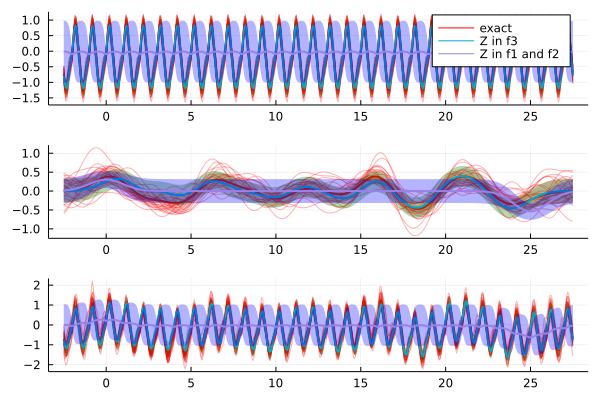

In [14]:
plot(f₁′_plot, f₂′_plot, f₃′_plot; layout=(3, 1))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*